# Final Project  
# Transfer Learning: Fruits 360 with ResNet34

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

## 0. Dataset and Description

**Name:**  Fruits 360
**Description:** this notebook uses the MNIST database to perform a supervised learning with the aim of image classification of handwritten digits.  
**Download:** https://www.kaggle.com/moltean/fruits/download


## 1. Libraries and packages

In [0]:
!pip install -q \
    numpy       \
    torch       \
    sklearn     \
    skorch      \
    matplotlib  

In [0]:
#-------------------------------------------------
# general
#-------------------
import pandas as pd
import numpy as np
import glob
from PIL import Image
from os import listdir
#-------------------------------------------------
# PyTorch
#-------------------
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.datasets import ImageFolder
#from torchvision.utils import make_grid
#-------------------------------------------------
# skorch
#-------------------
#from skorch.dataset import CVSplit
#-------------------------------------------------
# scikit-learn
#-------------------
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
#-------------------------------------------------
# data visualization
#-------------------
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython import display
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
torch.manual_seed(42);

### Check if GPU is available

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('GPU available:', device)

GPU available: cuda


## 2. Dataset loading

### 2.1 Mounting and unzipping dataset in Google Drive

In [4]:
# mounting
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# unzipping
!unzip -q -n "/gdrive/Shared drives/Drive compartilhado EA999/fruits.zip"

### 2.2 Transforms

### Resize

In [0]:
class Resize(object):
    def __init__(self, output_size):
        self.output_size = output_size
    def __call__(self, data):
        im = Image.Image()
        image = data.resize(self.output_size)
        return image

### ImageNet transforms

In [0]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

### Compose

In [0]:
# transforms
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()
#-------------------------------------------------
resize_image = Resize(output_size=(224,224))
#-------------------------------------------------
compose_transform = [
    resize_image,
    pil2tensor,
    normalize,
]
#-------------------------------------------------
fruits_transforms = transforms.Compose(compose_transform)

### 2.3 PyTorch dataset creation

In [0]:
rootdir = 'fruits-360_dataset/fruits-360/'
train_path = rootdir + '/Training/'
test_path = rootdir + '/Test/'
#ds_train = ImageFolder(train_path, transform=transforms.ToTensor())
#ds_test = ImageFolder(test_path, transform=transforms.ToTensor())
ds_train = ImageFolder(train_path, transform=fruits_transforms)
ds_test = ImageFolder(test_path, transform=fruits_transforms)

In [10]:
print(ds_train)

Dataset ImageFolder
    Number of datapoints: 60498
    Root location: fruits-360_dataset/fruits-360//Training/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [11]:
print(ds_test)

Dataset ImageFolder
    Number of datapoints: 20622
    Root location: fruits-360_dataset/fruits-360//Test/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


## 3. Network Model

In [0]:
N_SAMPLES = len(ds_train)
#V_SAMPLES = len(ds_val)
V_SAMPLES = len(ds_test)
N_CLASSES = len(glob.glob('fruits-360_dataset/fruits-360/Training/*'))

### Loading parameters from previous trained network

In [0]:
class FC(torch.nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc = torch.nn.Linear(in_features=512, out_features=N_CLASSES)
    def forward(self, x):
        return self.fc(x)

In [14]:
# Loading model
model = FC()
model.load_state_dict(torch.load('model_state_dict.pt'))

<All keys matched successfully>

### Base network: ResNet34

In [0]:
# importing the model
import torchvision.models as models
resnet34 = models.resnet34(pretrained=True)

### Modifying ResNet's last layer

In [0]:
# change last layer
resnet34.fc = model.fc
#resnet34.to(device);
#-------------------
# freeze all weights
for param in resnet34.parameters():
    param.requires_grad = False
#-------------------
# unfreeze only last layer
for param in resnet34.layer4.parameters():
    param.requires_grad = True
#-------------------
resnet34.to(device);

### Creating Dataloader for training

In [0]:
BATCH_SIZE = 100
#-------------------
# DataLoader for training set
dl_train = DataLoader(
    ds_train, 
    batch_size=BATCH_SIZE,
    drop_last = False,
    shuffle = True)

### Creating Dataloader for validation

In [0]:
BATCH_SIZE = 100
#-------------------
# # DataLoader for validation set
# dl_val = DataLoader(
#     ds_val, 
#     batch_size=PREDICTION_BATCH,
#     drop_last = False,
#     shuffle = False)
#-------------------
# DataLoader for test set
dl_test = DataLoader(
    ds_test, 
    batch_size=BATCH_SIZE,
    drop_last = False,
    shuffle = True)

## 4. Network training

### 4.1 Training definitions

- number of epochs
- optimizer and LR (learning rate)
- loss function


In [0]:
# Training parameters
EPOCH = 20
LR = 0.001
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(resnet34.parameters(), lr=LR)
# loss history
loss_his = []
loss_val_his = []

### 4.2 Training loop

In [21]:
for epoch in range(EPOCH):
    print('epoch =', epoch, end='; ')
    #-------------------------------------------------
    # training
    resnet34.train()
    zero_one_loss = 0.
    for b_i, (b_x, b_y) in enumerate(dl_train):   # for each training step
        b_x, b_y = b_x.to(device), b_y.to(device)
        y_logitos = resnet34(b_x)
        loss = loss_func(y_logitos, b_y)
        opt.zero_grad()                 # clear gradients for next train
        loss.backward()                 # backpropagation, compute gradients
        opt.step()                      # apply gradients
        #-------------------
        y_pred = torch.argmax(y_logitos, dim=1)
        zero_one_loss += (b_y == y_pred).sum()
    acc_train = zero_one_loss / N_SAMPLES
    #-------------------------------------------------
    # validation
    resnet34.eval()
    zero_one_loss_val = 0.
    for b_ival, (b_xval, b_yval) in enumerate(dl_test):
        b_xval, b_yval = b_xval.to(device), b_yval.to(device)
        y_logitos = resnet34(b_xval)
        loss_val = loss_func(y_logitos, b_yval)
        yval_pred = torch.argmax(y_logitos, dim=1)
        zero_one_loss_val += (b_yval == yval_pred).sum()
    #-------------------------------------------------
    loss_his.append(loss.item())    # loss recoder
    loss_val_his.append(loss_val.item())    # loss recoder
    acc_val = zero_one_loss_val / len(ds_test)
    #-------------------------------------------------
    print('loss_train = {0:.4f}'.format(loss_his[-1]), end='; ')
    print('loss_val = {0:.4f}'.format(loss_val_his[-1]), end='; ')
    print('acc_train = {0:.4f}'.format(acc_train), end='; ')
    print('acc_val = {0:.4f}'.format(acc_val), end='\n')

epoch = 0; epoch = 0; loss_train = 0.0394; loss_val = 0.0920; acc_train = 0.9995; acc_val = 0.9893
epoch = 1; loss_train = 0.0394; loss_val = 0.0920; acc_train = 0.9995; acc_val = 0.9893
epoch = 1; loss_train = 0.0533; loss_val = 0.0293; acc_train = 0.9995; acc_val = 0.9899
epoch = 2; loss_train = 0.0533; loss_val = 0.0293; acc_train = 0.9995; acc_val = 0.9899
epoch = 2; loss_train = 0.0378; loss_val = 0.0621; acc_train = 0.9997; acc_val = 0.9900
epoch = 3; loss_train = 0.0378; loss_val = 0.0621; acc_train = 0.9997; acc_val = 0.9900
epoch = 3; loss_train = 0.0367; loss_val = 0.0446; acc_train = 0.9996; acc_val = 0.9907
epoch = 4; loss_train = 0.0367; loss_val = 0.0446; acc_train = 0.9996; acc_val = 0.9907
epoch = 4; loss_train = 0.0540; loss_val = 0.0404; acc_train = 0.9998; acc_val = 0.9906
epoch = 5; loss_train = 0.0540; loss_val = 0.0404; acc_train = 0.9998; acc_val = 0.9906
epoch = 5; loss_train = 0.0229; loss_val = 0.0664; acc_train = 0.9998; acc_val = 0.9909
epoch = 6; loss_train

## 5. Performance evaluation

- metrics:
  - accuracy
  - confusion matrix
  - others

### Calculating accuracy of whole network

In [0]:
# DataLoader for test set
dl_test = DataLoader(
    ds_test, 
    batch_size=BATCH_SIZE,
    drop_last = False,
    shuffle = False)

In [25]:
# validation
resnet34.eval()
zero_one_loss_val = 0.
y_pred_final = torch.zeros(V_SAMPLES, dtype=torch.int64)

for b_ival, (b_xval, b_yval) in enumerate(dl_test):
    b_xval, b_yval = b_xval.to(device), b_yval.to(device)
    y_logitos = resnet34(b_xval)
    yval_sm = torch.nn.functional.softmax(y_logitos, dim=1)
    yval_pred = torch.argmax(yval_sm, dim=1)
    y_pred_final[b_ival*BATCH_SIZE:(b_ival+1)*BATCH_SIZE,] = yval_pred
    zero_one_loss_val += (b_yval != yval_pred).sum()
    print(b_ival, int(zero_one_loss_val))

0 0
1 0
2 0
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 4
11 5
12 5
13 22
14 54
15 54
16 54
17 54
18 54
19 54
20 54
21 54
22 54
23 54
24 54
25 54
26 55
27 55
28 55
29 55
30 55
31 78
32 82
33 82
34 82
35 82
36 82
37 82
38 82
39 82
40 82
41 82
42 82
43 82
44 82
45 82
46 82
47 82
48 82
49 82
50 82
51 82
52 82
53 82
54 82
55 83
56 83
57 83
58 83
59 83
60 83
61 103
62 108
63 108
64 108
65 108
66 108
67 108
68 108
69 108
70 108
71 108
72 108
73 108
74 108
75 108
76 108
77 108
78 108
79 108
80 108
81 108
82 108
83 108
84 108
85 108
86 109
87 109
88 109
89 109
90 109
91 109
92 109
93 109
94 109
95 109
96 109
97 109
98 109
99 109
100 109
101 109
102 109
103 109
104 109
105 109
106 109
107 109
108 109
109 109
110 109
111 109
112 109
113 110
114 110
115 110
116 110
117 111
118 111
119 111
120 133
121 134
122 134
123 134
124 134
125 135
126 135
127 135
128 135
129 135
130 135
131 135
132 140
133 151
134 151
135 151
136 151
137 151
138 151
139 151
140 151
141 151
142 151
143 151
144 151
145 163
146 163
147 164


### Final metrics values:

In [26]:
print('last training loss = {0:.4f}'.format(loss_his[-1]))
print('last validation loss = {0:.4f}'.format(loss_val_his[-1]))
print('#-------------------------------------------------')
print('last train accuracy = {0:.4f}'.format(acc_train.item()))
print('last validation accuracy = {0:.4f}'.format(acc_val.item()))

last training loss = 0.0214
last validation loss = 0.0292
#-------------------------------------------------
last train accuracy = 0.9999
last validation accuracy = 0.9916


### Function to plot confusion matrix

In [0]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, title=None, normalize=False, cmap=plt.cm.Blues, figsize = (10,7), fontsize=14):
    # normalized or raw CM
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    #----------------------------
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    #----------------------------
    # fix matplotlib 3.1.1 bug
    #heatmap.get_ylim() --> (5.5, 0.5)
    #heatmap.set_ylim(6.0, 0)
    #----------------------------
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### Confusion Matrix

In [0]:
y_pred = np.array(y_pred_final)
y_true = np.array(ds_test.targets)
cm = confusion_matrix(y_true, y_pred)
classes = np.asarray(ds_test.classes)

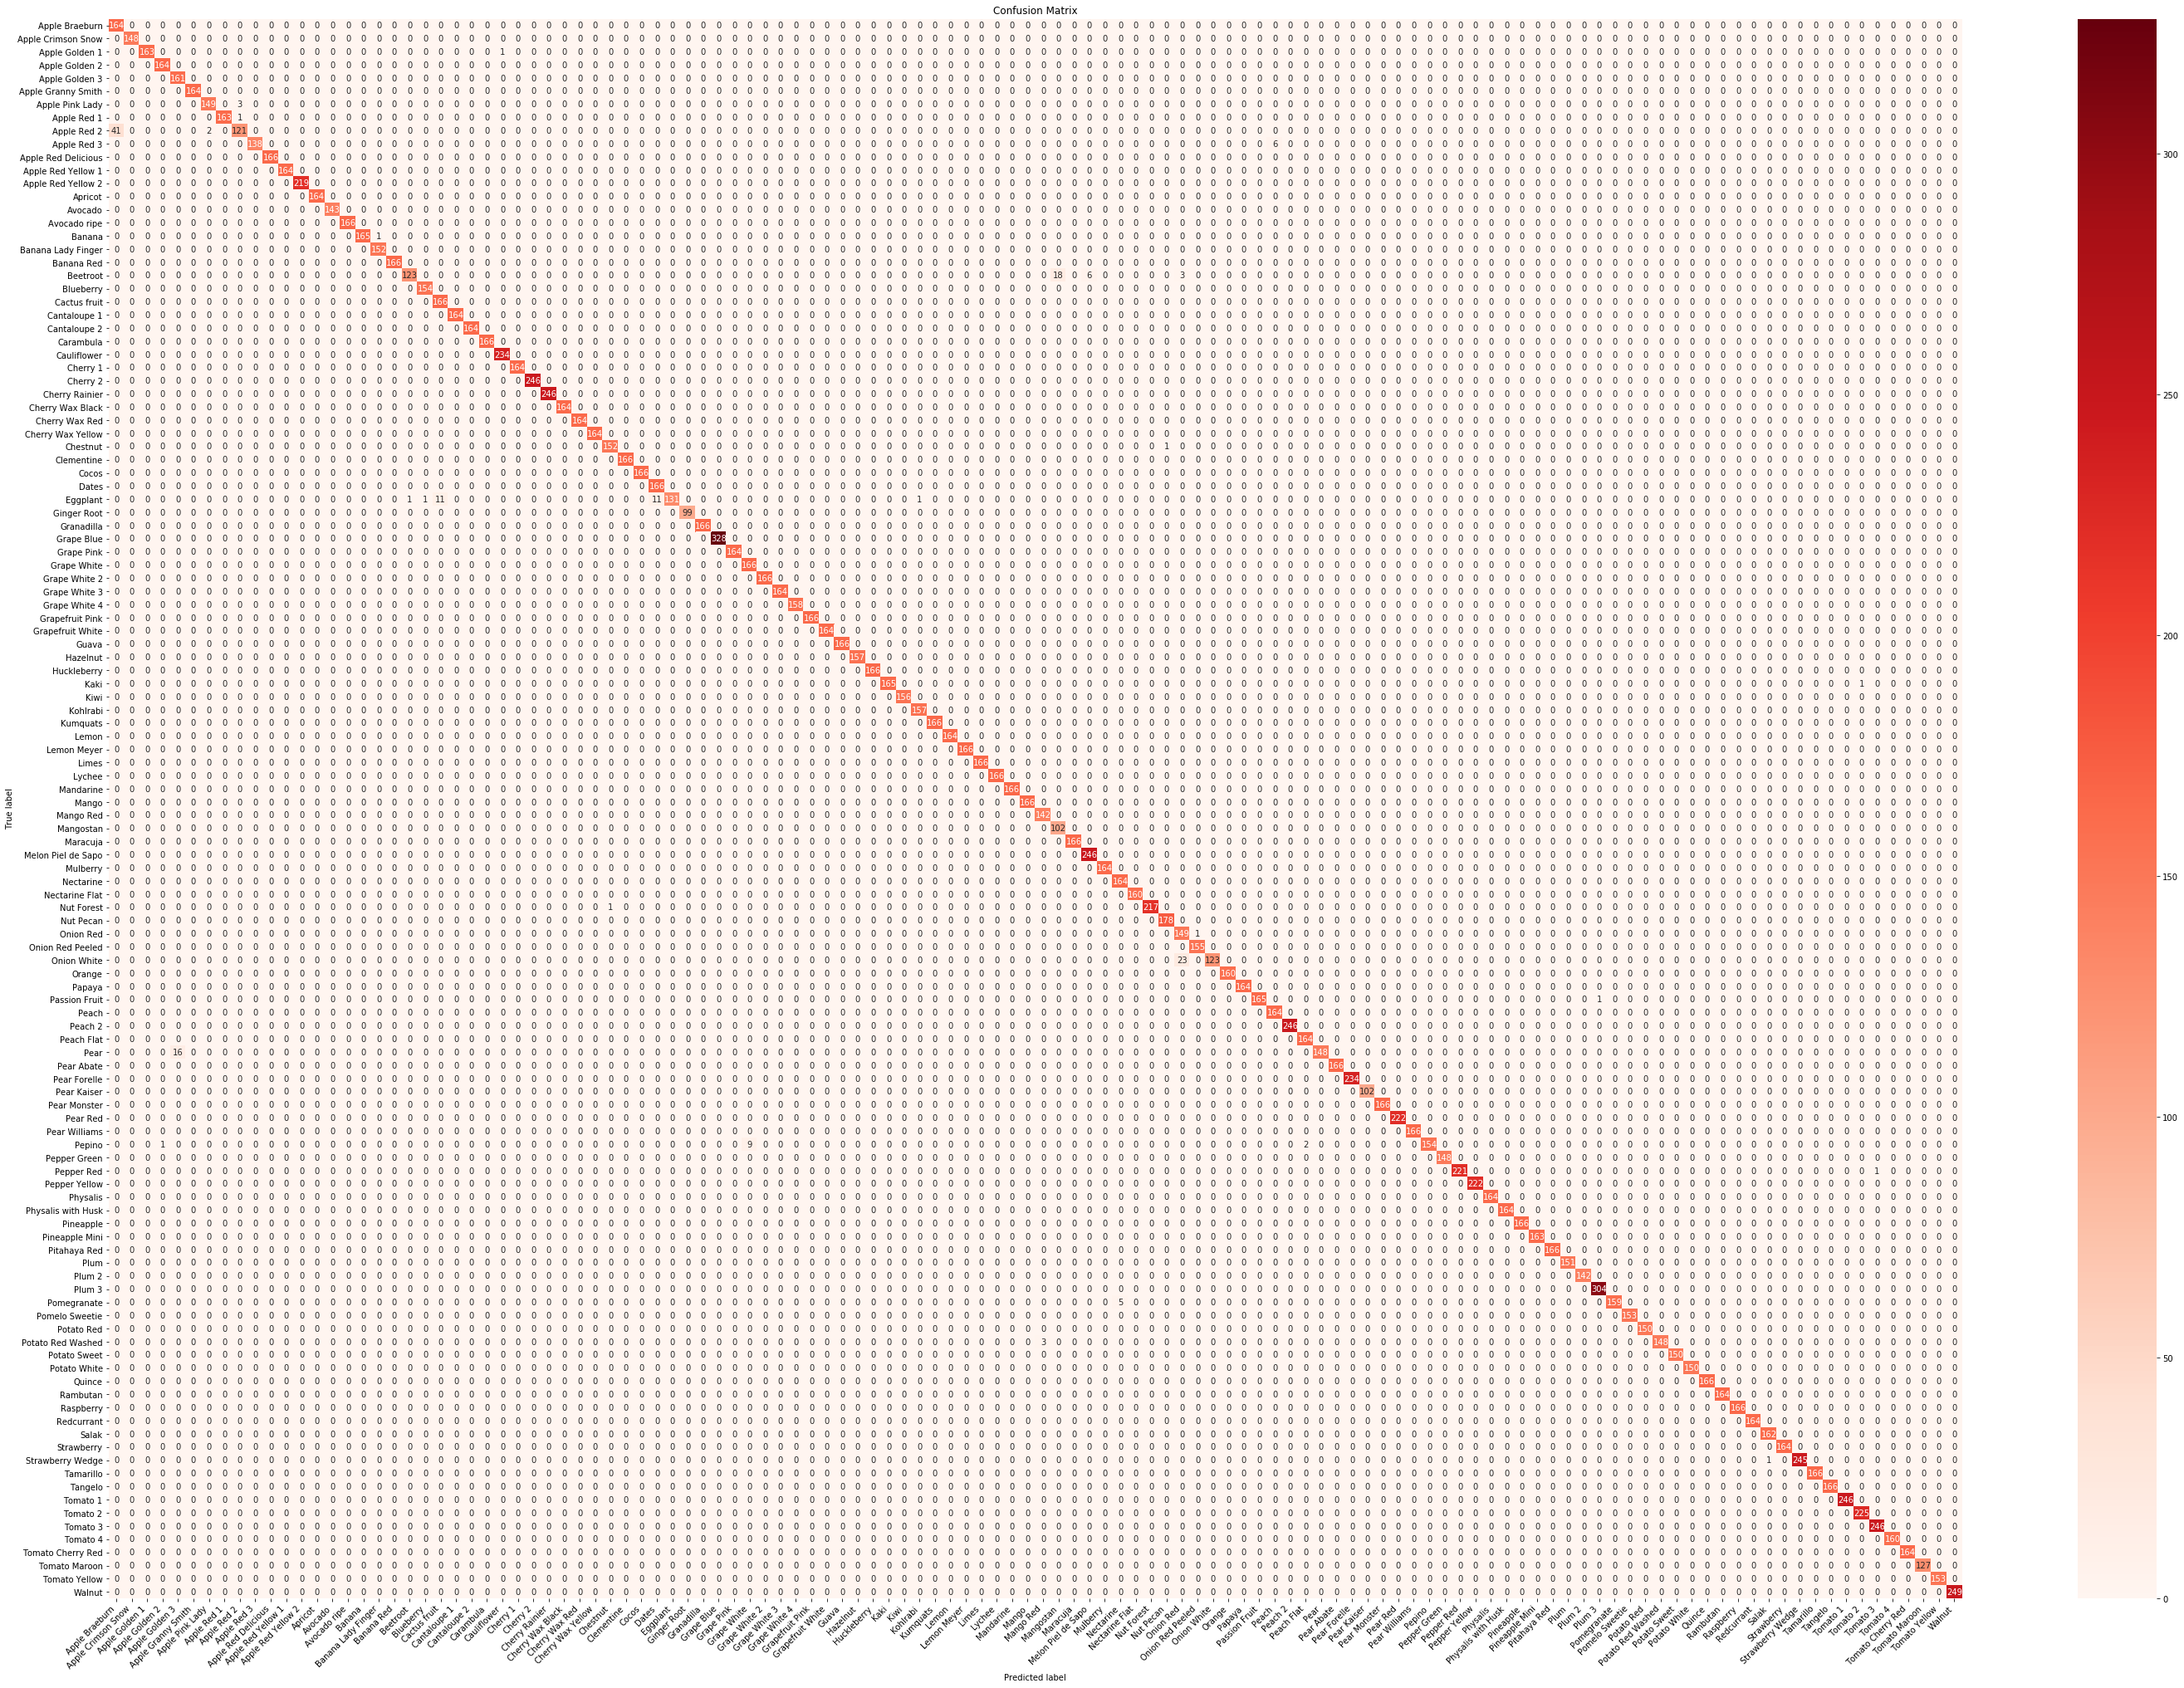

In [29]:
# CM raw
cm_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, figsize = (50,35), cmap=plt.cm.Reds, fontsize=10)

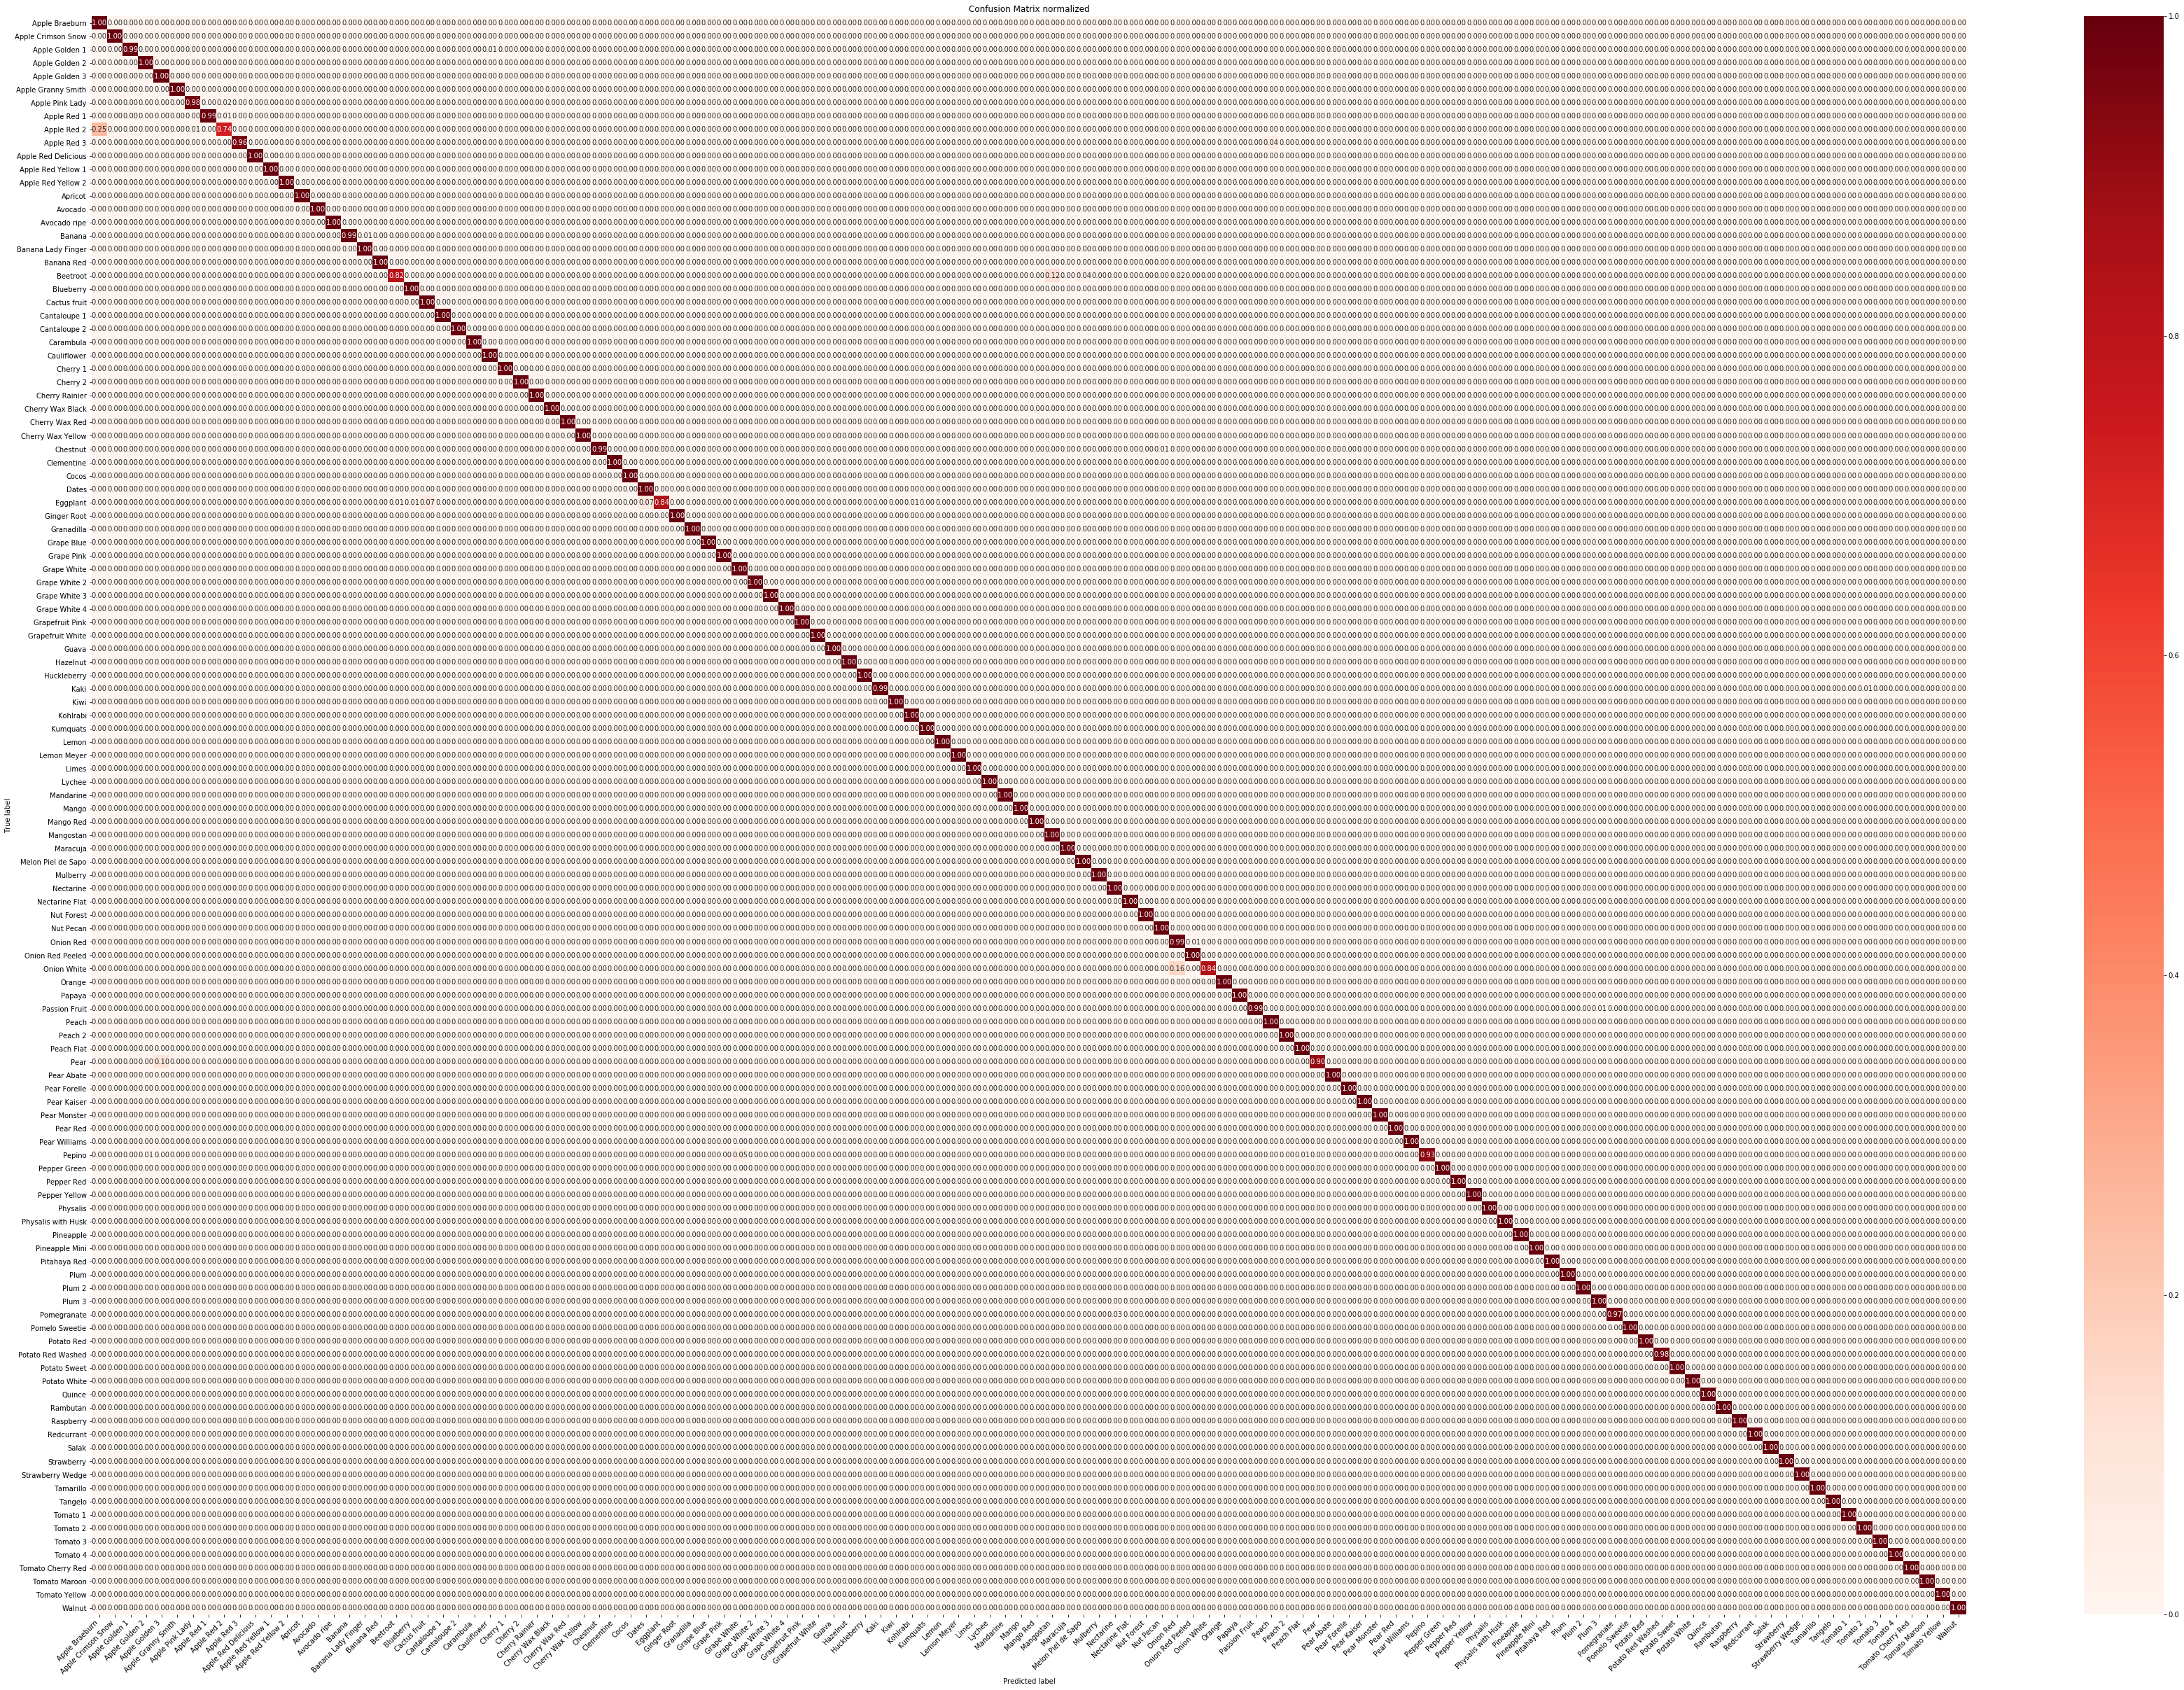

In [30]:
# CM normalized
cm_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix normalized', normalize=True, figsize = (60,42), cmap=plt.cm.Reds, fontsize=10)

### F1-score (macro, micro and weighted)

In [0]:
macro = f1_score(y_true, y_pred, average='macro')
micro = f1_score(y_true, y_pred, average='micro')
weighted = f1_score(y_true, y_pred, average='weighted')

In [32]:
print('F1-score macro =', macro)
print('F1-score micro =', micro)
print('F1-score weighted =', weighted)

F1-score macro = 0.9906472160480863
F1-score micro = 0.9916109009795364
F1-score weighted = 0.9915001745114923


### Accuracy and Precision

In [0]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')

In [34]:
print('Accuracy score = ', acc, sep='')
print('Precision score = ', prec, sep='')

Accuracy score = 0.9916109009795364
Precision score = 0.9916210123445631


### Precision, Recall and F1-Score for each class

In [35]:
from sklearn.metrics import classification_report as cr
print(cr(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       164
           1       1.00      1.00      1.00       148
           2       1.00      0.99      1.00       164
           3       0.99      1.00      1.00       164
           4       0.91      1.00      0.95       161
           5       1.00      1.00      1.00       164
           6       0.99      0.98      0.98       152
           7       1.00      0.99      1.00       164
           8       0.97      0.74      0.84       164
           9       1.00      0.96      0.98       144
          10       1.00      1.00      1.00       166
          11       1.00      1.00      1.00       164
          12       1.00      1.00      1.00       219
          13       1.00      1.00      1.00       164
          14       1.00      1.00      1.00       143
          15       1.00      1.00      1.00       166
          16       1.00      0.99      1.00       166
          17       0.99    